In [30]:
import pandas as pd
import geopandas
import re

import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
%matplotlib notebook

import datetime


In [6]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

from sklearn import metrics

In [7]:
df = pd.read_csv('data/data_processed.csv')

df_train = df[df['month'] < 12]
df_test = df[df['month'] == 12]


features = ['weekday', 'season', 'tavg', 'prcp',
            'wspd', 'loc_x', 'loc_y', 'rank_station']
target = 'num_rentals'

In [16]:
model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.3)
model = XGBRegressor()

model.fit(df_train[features], df_train[target])

df_test.loc[:, 'num_rentals_pred'] = list(model.predict(df_test[features]))

mse = metrics.mean_squared_error(
    df_test[target], df_test[target+'_pred'])/(np.mean(df_test[target+'_pred'])**2)
mae = metrics.mean_absolute_error(
    df_test[target], df_test[target+'_pred'])/(np.mean(df_test[target+'_pred']))
r2 = metrics.r2_score(df_test[target], df_test[target+'_pred'])
print(mse, mae, r2)

0.21069431090968108 0.3672489925729864 0.13021400639070146


In [50]:
fig = go.Figure(
    data=[
        go.Scatter(x=df_test[target], y=df_test[target+"_pred"],
                   mode="markers"),
        go.Scatter(x=np.arange(150), y=np.arange(150),
                   mode="lines")
    ]
)
fig.update_layout(
    showlegend=False,
    xaxis_title="True",
    yaxis_title="Predicted",
    title="Prediction demand per station for December 2023"
)

fig.show()

In [65]:
import plotly.express as px
day_number = 362

df_for_plot = df_test
# df_for_plot = df_for_plot.groupby('unlock_station_name')[['num_rentals', 'loc_x', 'loc_y']].mean()

gdf_plot = geopandas.GeoDataFrame(
    df_for_plot, geometry=geopandas.points_from_xy(df_for_plot.loc_x, df_for_plot.loc_y), crs="EPSG:4326")

fig = px.density_mapbox(gdf_plot, lat='loc_y', lon='loc_x', z='num_rentals', animation_frame='day_number',
                        radius=11,
                        center=dict(lat=gdf_plot.loc_y.median(),
                                    lon=gdf_plot.loc_x.median()),
                        zoom=10.6,
                        mapbox_style='open-street-map',
                        range_color=[0, 10], height=600, width=600)


fig.show()
# df_for_plot = df_for_plot.groupby('unlock_station_name')[['num_rentals_pred', 'loc_x', 'loc_y']].mean()

df_for_plot = df_test

gdf_plot = geopandas.GeoDataFrame(
    df_for_plot, geometry=geopandas.points_from_xy(df_for_plot.loc_x, df_for_plot.loc_y), crs="EPSG:4326")

fig = px.density_mapbox(gdf_plot, lat='loc_y', lon='loc_x', z='num_rentals_pred', animation_frame='day_number',
                        radius=11,
                        center=dict(lat=gdf_plot.loc_y.median(),
                                    lon=gdf_plot.loc_x.median()),
                        zoom=10.5,
                        mapbox_style='open-street-map',
                        range_color=[0, 10], height=600, width=600)
fig.show()
fig.write_html('test.html')

In [11]:
import plotly.io as pio
days_test_set = sorted(df_test.day_number.unique())

for day in days_test_set:
    df_for_plot = df_test[df_test['day_number'] == day]
    # df_for_plot = df_for_plot.groupby('unlock_station_name')[['num_rentals', 'loc_x', 'loc_y']].mean()

    gdf_plot = geopandas.GeoDataFrame(
        df_for_plot, geometry=geopandas.points_from_xy(df_for_plot.loc_x, df_for_plot.loc_y), crs="EPSG:4326")

    fig = px.density_mapbox(gdf_plot, lat='loc_y', lon='loc_x', z='num_rentals',
                            radius=11,
                            center=dict(lat=df_test.loc_y.median(),
                                        lon=df_test.loc_x.median()),
                            zoom=10.6,
                            mapbox_style='open-street-map',
                            range_color=[0, 10], height=600, width=600)
    pio.write_image(fig, f"images_animation/test_pred/fig{day}.png")

In [22]:
import plotly.io as pio
for day in days_test_set:
    df_for_plot = df_test[df_test['day_number'] == day]
    # df_for_plot = df_for_plot.groupby('unlock_station_name')[['num_rentals', 'loc_x', 'loc_y']].mean()

    gdf_plot = geopandas.GeoDataFrame(
        df_for_plot, geometry=geopandas.points_from_xy(df_for_plot.loc_x, df_for_plot.loc_y), crs="EPSG:4326")

    fig = px.density_mapbox(gdf_plot, lat='loc_y', lon='loc_x', z='num_rentals_pred',
                            radius=11,
                            center=dict(lat=df_test.loc_y.median(),
                                        lon=df_test.loc_x.median()),
                            zoom=10.6,
                            mapbox_style='open-street-map',
                            range_color=[0, 10], height=600, width=600)

    pio.write_image(fig, f"images_animation/test_true/fig{day}.png")

<IPython.core.display.Javascript object>


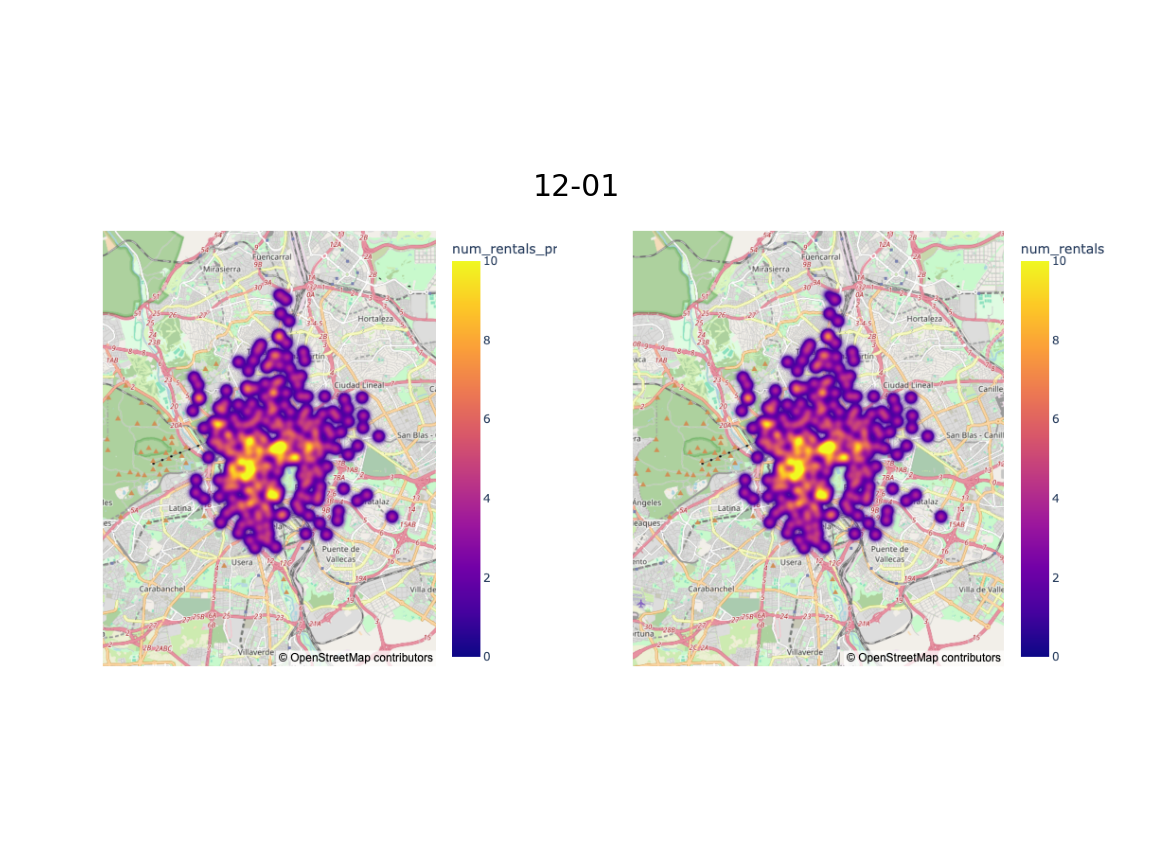

In [45]:
from PIL import Image

frames_true = [Image.open(
    f"images_animation/test_true/fig{day}.png") for day in days_test_set]
frames_pred = [Image.open(
    f"images_animation/test_pred/fig{day}.png") for day in days_test_set]


for i, day in enumerate(days_test_set[:1]):
    fig, axs = plt.subplots(1, 2)

    axs[0].imshow(frames_true[i])
    axs[1].imshow(frames_pred[i])
    plt.suptitle(datetime.datetime.strptime(
        str(day), "%j").strftime("%m-%d"), y=0.8)

    for ax in axs:
        ax.axis('off')
    plt.tight_layout(w_pad=-1.5)

    plt.savefig(f'images_animation/test/fig{day}.png',
                dpi=300, transparent=True, bbox_inches='tight')

In [46]:
from PIL import Image
import glob
frames = [Image.open(
    f"images_animation/test/fig{day}.png") for day in days_test_set]


frame_one = frames[0]
frame_one.save("test.gif", format="GIF", append_images=frames,
               save_all=True, duration=1000, loop=0)